In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px

In [2]:
sns.set(
    rc={
        "figure.figsize": (12, 8), #размер графика - 12 дюймов в ширину, 8 в длину
        "axes.titlesize": 20, #размер заголовка 
        "axes.labelsize": 14, #размер подписей осей
        "xtick.labelsize": 13, #размер подписей чёрточек на x-оси
        "ytick.labelsize": 13, #размер подписей чёрточек на y-оси
    }
)

sns.set_style("whitegrid") #тема фона, белая со штриховкой

Представьте, что вы работаете аналитиком в компании, которая занимается арендой велосипедов. Коллега из офиса в Лондоне прислал вам данные за два года: с 4 января 2015 по 3 января 2017. Вам предстоит изучить динамику числа аренд, наличие связи с погодными условиями и выходными, а также объяснить несколько аномалий на графике.
### Описание данных
- timestamp – дата и время (точность до часа)
- cnt – количество аренд велосипедов за этот час
- t1 – температура, в С
- t2 – температура "ощущается как", в С 
- hum – влажность (%)
- wind_speed – скорость ветра, км/ч
- isholiday – является ли день праздником (1 – праздник, 0 – нет)
- isweekend –  является ли день выходным (1 – выходной, 0 – нет)
- season – метеорологический сезон (0 – весна, 1 – лето, 2 – осень, 3 – зима)

### weather_code – погодные условия:
- 1 – ясно (SKC)
- 2 – преимущественно ясно / встречаются отдельные облака (SCT)
- 3 – облачно / значительные облака (BKN)
- 4 – пасмурно (OVC)
- 7 – небольшой дождь Rain/ light Rain shower/ Light rain 
- 10 – дождь с грозой
- 26 – снегопад 
- 94 – ледяной туман (да, такое бывает!)

In [3]:
df = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/c4t6B6OFDANVbg', parse_dates=['timestamp'])
df.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [4]:
df.info() # в данных нет пропусков

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   timestamp     17414 non-null  datetime64[ns]
 1   cnt           17414 non-null  int64         
 2   t1            17414 non-null  float64       
 3   t2            17414 non-null  float64       
 4   hum           17414 non-null  float64       
 5   wind_speed    17414 non-null  float64       
 6   weather_code  17414 non-null  float64       
 7   is_holiday    17414 non-null  float64       
 8   is_weekend    17414 non-null  float64       
 9   season        17414 non-null  float64       
dtypes: datetime64[ns](1), float64(8), int64(1)
memory usage: 1.3 MB


In [5]:
df.duplicated().sum() # нет дубликатов

0

### 1. Для начала попробуем посмотреть на число поездок по датам и времени. Постройте график, где:

по оси x – дата (timestamp)
по оси y – число поездок (cnt)

In [6]:
rides_dy_day = df.groupby('timestamp', as_index=False) \
                .agg({'cnt': 'sum'})

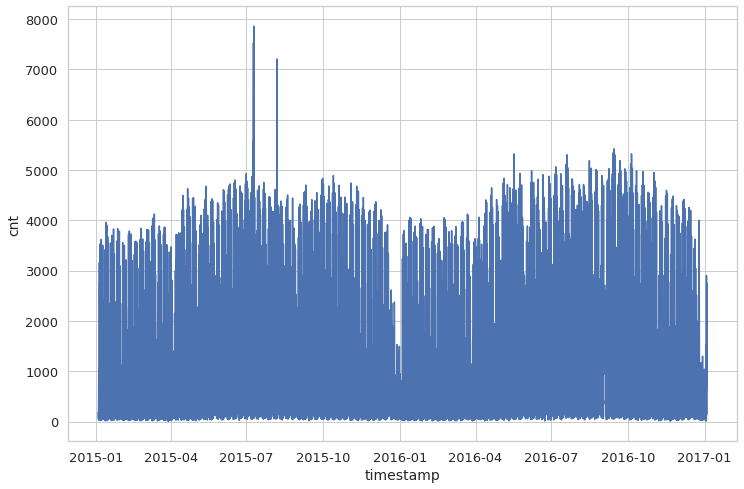

In [7]:
sns.lineplot(data=rides_dy_day, x='timestamp', y='cnt')

- Встречаются как очень резкие скачки числа аренд, так и падения
- Зимой число аренд меньше, чем летом
- Максимальное число аренд за день составляет более 70 000

### Приведем график к более читаемому виду через resample:

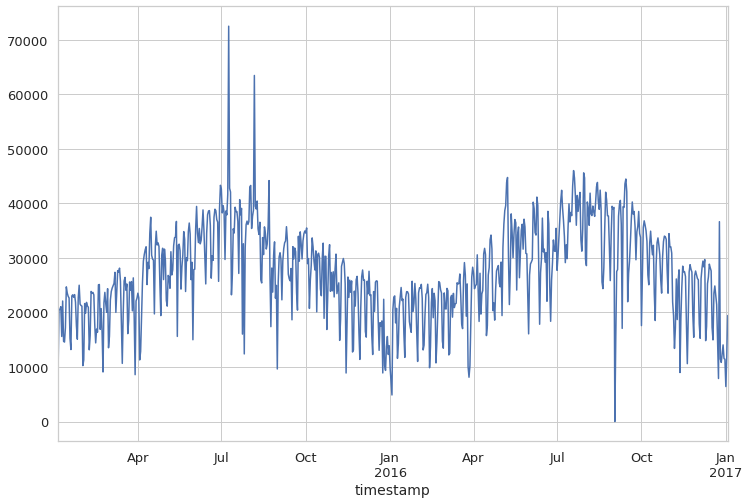

In [8]:
df_resample = df.set_index('timestamp').resample('D').cnt.sum()
df_resample.plot() #способ 1

In [9]:
# data.resample(rule='D').agg({'column_name':'sum'}) способ 2, эквивалентный предыдущему

### Необъодимо разобраться со скачками - рассчитать доверительные интервалы при помощи скользящего среднего

Мы не можем просто так посчитать доверительный интервал для всего: так мы можем упустить важные характеристики данных! Например, сезонные колебания. 

Чтобы учесть этот момент, мы построим доверительный интервал, используя скользящее среднее. Для этого разделим дальнейшие действия на несколько этапов:

сначала посчитаем скользящее среднее, чтобы сгладить ряд
далее – разницу между наблюдаемыми и сглаженными значениями
определим верхние и нижние границы 99% доверительного интервала 
найдем причины аномалий!

### На данном шаге возьмите агрегированные данные по дням с предыдущего шага и посчитайте скользящее среднее с окном 3. В качестве ответа укажите полученное число аренд за 2015-07-09, округлив значение до целого.

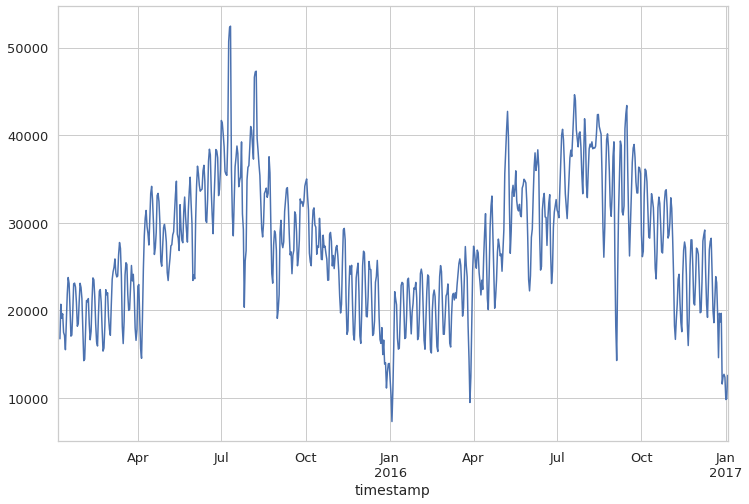

In [10]:
df_resample.rolling(3).mean().plot()

In [11]:
df_resample.rolling(3).mean()

timestamp
2015-01-04             NaN
2015-01-05             NaN
2015-01-06    16739.666667
2015-01-07    20683.000000
2015-01-08    19092.666667
                  ...     
2016-12-30    12682.000000
2016-12-31    12347.333333
2017-01-01     9803.666667
2017-01-02     9889.333333
2017-01-03    12560.000000
Freq: D, Name: cnt, Length: 731, dtype: float64

In [12]:
df_resample.rolling(3).mean().reset_index().query("timestamp == '2015-07-09'")

,timestamp,cnt
186,2015-07-09,50705.0


### Теперь посчитайте разницу между наблюдаемыми и подсчитанными значениями.

In [13]:
df.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [14]:
df1 = df[['timestamp', 'cnt']]

In [15]:
df_by_days = df_resample.rolling(3).mean().reset_index()
df_by_days

,timestamp,cnt
0,2015-01-04,NaN
1,2015-01-05,NaN
2,2015-01-06,16739.666667
3,2015-01-07,20683.000000
4,2015-01-08,19092.666667
...,...,...
726,2016-12-30,12682.000000
727,2016-12-31,12347.333333
728,2017-01-01,9803.666667
729,2017-01-02,9889.333333


In [16]:
df1 = df1.set_index('timestamp').resample('D').agg({'cnt': 'sum'}).reset_index()

In [17]:
df1['diff'] = df1['cnt'] - df_resample.rolling(3).mean().reset_index().cnt

In [18]:
df1

,timestamp,cnt,diff
0,2015-01-04,9234,NaN
1,2015-01-05,20372,NaN
2,2015-01-06,20613,3873.333333
3,2015-01-07,21064,381.000000
4,2015-01-08,15601,-3491.666667
...,...,...,...
726,2016-12-30,11566,-1116.000000
727,2016-12-31,11424,-923.333333
728,2017-01-01,6421,-3382.666667
729,2017-01-02,11823,1933.666667


In [19]:
std = np.std(df1['diff'])
round(std, 2)

4558.59

In [20]:
df1['rolling'] = df_by_days['cnt']

In [21]:
df1

,timestamp,cnt,diff,rolling
0,2015-01-04,9234,NaN,NaN
1,2015-01-05,20372,NaN,NaN
2,2015-01-06,20613,3873.333333,16739.666667
3,2015-01-07,21064,381.000000,20683.000000
4,2015-01-08,15601,-3491.666667,19092.666667
...,...,...,...,...
726,2016-12-30,11566,-1116.000000,12682.000000
727,2016-12-31,11424,-923.333333,12347.333333
728,2017-01-01,6421,-3382.666667,9803.666667
729,2017-01-02,11823,1933.666667,9889.333333


In [22]:
df1=df1.reindex(columns=['timestamp', 'cnt', 'rolling', 'diff'])

In [23]:
df1

,timestamp,cnt,rolling,diff
0,2015-01-04,9234,NaN,NaN
1,2015-01-05,20372,NaN,NaN
2,2015-01-06,20613,16739.666667,3873.333333
3,2015-01-07,21064,20683.000000,381.000000
4,2015-01-08,15601,19092.666667,-3491.666667
...,...,...,...,...
726,2016-12-30,11566,12682.000000,-1116.000000
727,2016-12-31,11424,12347.333333,-923.333333
728,2017-01-01,6421,9803.666667,-3382.666667
729,2017-01-02,11823,9889.333333,1933.666667


### определим границы интервалов. Для этого нужно взять данные, полученные при расчете скользящего среднего, и создать следующие объекты:

upper_bound – верхняя граница; к скользящим средним прибавляем 2.576∗std
lower_bound – нижняя граница; вычитаем 2.576∗std
Полученные значения запишите в новые столбцы датафрейма с агрегированными данными.

Чему равно значение верхней границы для последнего наблюдения? Ответ укажите с точностью до 2 знаков после точки.

Note: в качестве std нужно брать стандартное отклонение без округления.

In [24]:
df1['lower_bound'] = round((df1['rolling'] - 2.576 * std), 2)
df1['upper_bound'] = round((df1['rolling'] + 2.576 * std), 2)

In [25]:
df1.tail(1)

,timestamp,cnt,rolling,diff,lower_bound,upper_bound
730,2017-01-03,19436,12560.0,6876.0,817.08,24302.92


### И наконец – изучим аномально высокие значения! Сначала выведите наблюдения, для которых наблюдаемые значения оказались больше верхней границы 99% доверительного интервала.

В какой день значение числа аренд оказалось наибольшим? Укажите дату в формате 2020-12-31.

In [26]:
df1.head()

,timestamp,cnt,rolling,diff,lower_bound,upper_bound
0,2015-01-04,9234,NaN,NaN,NaN,NaN
1,2015-01-05,20372,NaN,NaN,NaN,NaN
2,2015-01-06,20613,16739.666667,3873.333333,4996.75,28482.59
3,2015-01-07,21064,20683.000000,381.000000,8940.08,32425.92
4,2015-01-08,15601,19092.666667,-3491.666667,7349.75,30835.59


In [27]:
df1.query("cnt > upper_bound")

,timestamp,cnt,rolling,diff,lower_bound,upper_bound
186,2015-07-09,72504,50705.000000,21799.000000,38962.08,62447.92
214,2015-08-06,63468,46627.333333,16840.666667,34884.41,58370.25
609,2016-09-04,27512,14259.000000,13253.000000,2516.08,26001.92
721,2016-12-25,36653,19650.666667,17002.333333,7907.75,31393.59


In [28]:
for i in df1.query("cnt > upper_bound").timestamp:
    print(i.date(), end=', ')

2015-07-09, 2015-08-06, 2016-09-04, 2016-12-25, 

### Подумайте, в чем может быть причина столь высокого числа аренд в этот день. Для этого можете исследовать уже имеющиеся переменные в датасете, проверить наличие ошибок в данных (повторяющихся строк), а также использовать поиск Google. 

In [29]:
df1.duplicated().sum()

0

In [30]:
#https://www.bbc.com/russian/international/2015/07/150709_london_tube_strike - забастовки в метро

In [31]:
df['timestamp1'] = pd.DatetimeIndex(df.timestamp).normalize()

In [32]:
query = df.query("timestamp1 == '2015-07-09' | timestamp1 == '2015-07-08' | timestamp1 == '2015-07-10'")

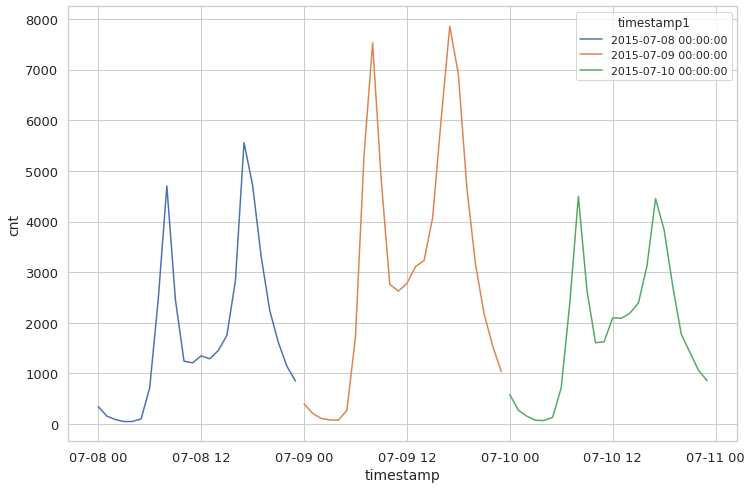

In [37]:
sns.lineplot(data = query, x='timestamp', y='cnt', hue='timestamp1')

### Проделайте аналогичную операцию для дней, когда число аренд оказалось ниже ожидаемого.

In [34]:
df1.query("cnt < lower_bound")

,timestamp,cnt,rolling,diff,lower_bound,upper_bound
130,2015-05-14,15609,28709.333333,-13100.333333,16966.41,40452.25
189,2015-07-12,23240,36036.666667,-12796.666667,24293.75,47779.59
201,2015-07-24,16034,31013.666667,-14979.666667,19270.75,42756.59
232,2015-08-24,17400,29529.333333,-12129.333333,17786.41,41272.25
314,2015-11-14,8898,21037.333333,-12139.333333,9294.41,32780.25
607,2016-09-02,0,26086.333333,-26086.333333,14343.41,37829.25
615,2016-09-10,17080,31262.000000,-14182.000000,19519.08,43004.92
621,2016-09-16,21967,36193.333333,-14226.333333,24450.41,47936.25
678,2016-11-12,8990,20878.000000,-11888.000000,9135.08,32620.92


### В чем может быть причина падения числа аренд 2016-09-02?

In [35]:
# Ошибка при сборе данных